In [ ]:
!unzip "C:\Users\HP\Downloads\DiabeticRetinopathy.pth.zip"

In [ ]:
bs = 32

In [ ]:
from pathlib import Path
from fastai.vision import *
import numpy as np
path = Path('/content/Diabetic Retinopathy')
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                  ds_tfms=get_transforms(),bs=bs, size=224, num_workers=4).normalize(imagenet_stats)

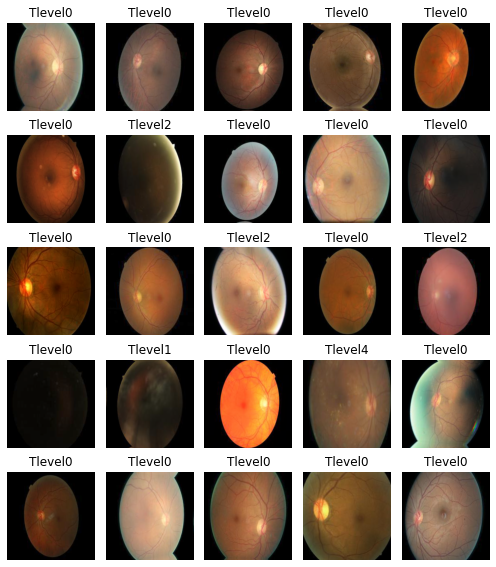

In [ ]:
data.show_batch(rows=5, figsize=(7, 8))

In [ ]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.densenet169, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.149462,0.924726,0.280354,05:19
1,0.859520,0.782039,0.251473,05:18
2,0.795325,0.781413,0.244597,05:17
3,0.724650,0.708774,0.233988,05:18
4,0.742488,0.678130,0.224361,05:19
5,0.648806,0.669123,0.220629,05:19
6,0.633438,0.665536,0.217682,05:20
7,0.617911,0.658802,0.217092,05:20
8,0.602403,0.659992,0.213360,05:20
9,0.606203,0.658523,0.213163,05:19


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


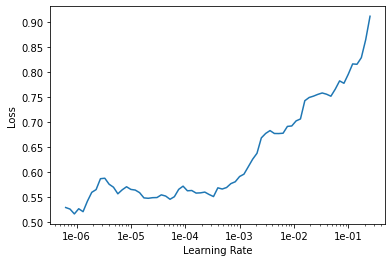

In [ ]:
learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [ ]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if self.best_acc == None or acc > self.best_acc:
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best accuracy {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Accuracy is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [ ]:
learn_densenet169 = cnn_learner(data, models.densenet169, metrics=accuracy,callback_fns=SaveBestModel)

In [ ]:
learn_densenet169.fit_one_cycle(15)

epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,1.215229,0.884184,0.739293,05:22
1,0.900747,0.791436,0.749312,05:23
2,0.812071,0.791652,0.751473,05:24
3,0.754074,0.764132,0.763851,05:21
4,0.742738,0.741188,0.769548,05:25
5,0.708156,0.693927,0.773870,05:23
6,0.688747,0.669484,0.779371,05:25
7,0.638654,0.668321,0.779371,05:23
8,0.620237,0.661081,0.786640,05:23


Save the best accuracy 0.73929
Save the best accuracy 0.74931
Save the best accuracy 0.75147
Save the best accuracy 0.76385
Save the best accuracy 0.76955
Save the best accuracy 0.77387
Save the best accuracy 0.77937
Accuracy is eq,Save the lower loss 0.66832
Save the best accuracy 0.78664
Save the best accuracy 0.78978


In [ ]:
learn_densenet169.save('densenet169_diabetic')

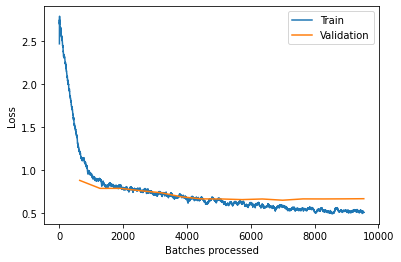

In [ ]:
learn_densenet169.recorder.plot_losses()

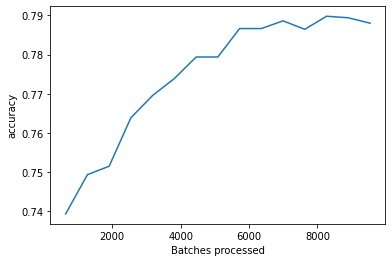

In [ ]:
learn_densenet169.recorder.plot_metrics()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_densenet169)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

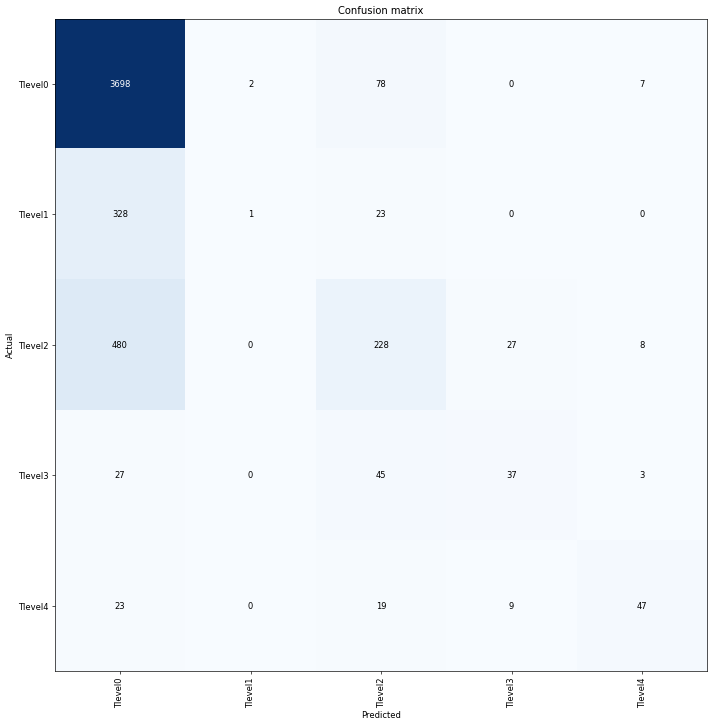

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage

import gc

In [ ]:
from gradcam import *

In [ ]:
def get_learner(data,is_fp16=False):
    gc.collect()
    learn = create_cnn(data, models.resnet50, metrics=accuracy)
    if is_fp16:
        learn = learn.to_fp16()
    return learn

In [ ]:
img = open_image('/content/Diabetic Retinopathy/Tlevel2/12003_right.jpeg');

CPU times: user 226 ms, sys: 7.69 ms, total: 234 ms
Wall time: 236 ms


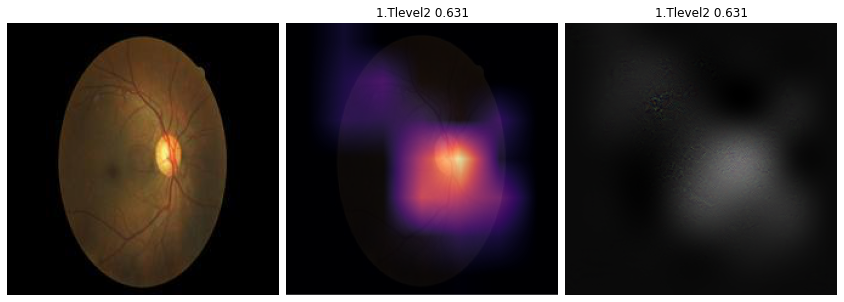

In [ ]:
%%time
gcam = GradCam.from_one_img(learn_densenet169,img)
gcam.plot()